<h1> QIBC analysis using PYTHON and JUPYTER notebook </h1>
<b> QIBC : Quantitative-image based cytometry
<b>This Notebook allows you to import data from the Image Xpress software<b>
<h2> WORKFLOW</h2>
    <ul>
        <li>Import results from data/folder</li>
        <li>Clean the data</li>
        <li>Import and Merge the platemap</li>
        <li>etc....</li>
    </ul>
    
<H2> EXAMPLE </H2>
For the purpose of this notebook, the experiment we're about to analyse is a follow :

<ul>
        <li>WT U2OS cells expressing a Xtagued GFP protein</li>
        <li>Treated for 6H with 10mM (HU). That's a high dose !</li>
        <li>Cells were pulse-labelled for 30 minutes with EDU (10mM) before HU treatment</li>
        <li>Cells have been stained for the phosphorilated version of H2AX </li>
    </ul>


In [1]:
# importing modules needed

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


#pd.__version__  #to check pandas version, we are using '0.23.4'

In [2]:
#Some constants

FILE = "Github-H2AX.csv" # NAME of the EXCEL FILE, located in data/ folder
PLATEMAP="platemap-H2AX.xlsx" # NAME of the xlsx Sheet containing the SAMPLES MAP

In [3]:
#read EXCEL FILE

df = pd.read_csv('data/' + FILE) #use  read_excel for xlsx files


#Some datas cleaning :

#df.drop(df[df.Wavelength == 'Wavelength'].index, inplace=True) #this has already been done


#split Stage Label in 2 columns (well and Site) present at the end of the DF
df[['Well','Site']] = df['Stage Label'].str.split(':',expand=True)
df = df.apply(pd.to_numeric, errors='ignore') #convert all numeric values to numeric

#let's create a subset of the dataframe with only the columns we want

df2= df.iloc[:,7:]
df2['Well'] = df2['Well'].str.strip() #remove the whitespace

#read the platemap :

#PLATE READER !!!

plate = pd.read_excel('data/' + PLATEMAP ).fillna('empty')
D={}
for i in plate.index :
    for j in plate.columns :
        if plate.loc[i,j] != 'empty':
            D[str(i)+str(j).zfill(2)] = plate.loc[i,j]
            
samples = pd.DataFrame.from_dict(D, orient='index', columns = ['sample'])
samples.index = samples.index.set_names(['Well'])
samples = samples.reset_index()

#merging Sample names with the results (merge on Wells)
 
df2= df2.merge(samples, on='Well')

#checking the results 
#df2.head()

In [5]:
#channel name 
GFP_avg ='Cell: FITC_Average_Intensity'
GFP_int ='Cell: FITC_Integrated_Intensity'
TRITC_avg ='Cell: TRITC_Average_Intensity'
TRITC_int = 'Cell: TRITC_Integrated_Intensity'
EDU_avg = 'Cell: CY5_Average_Intensity'
EDU_int ='Cell: CY5_Integrated_Intensity'
DAPI_int ='Cell: DAPI_Integrated_Intensity'
DAPI_avg ='Cell: DAPI_Average_Intensity'


Looking for outliers wells !
Each sample are in 3 wells, but is there any well that could be off ?



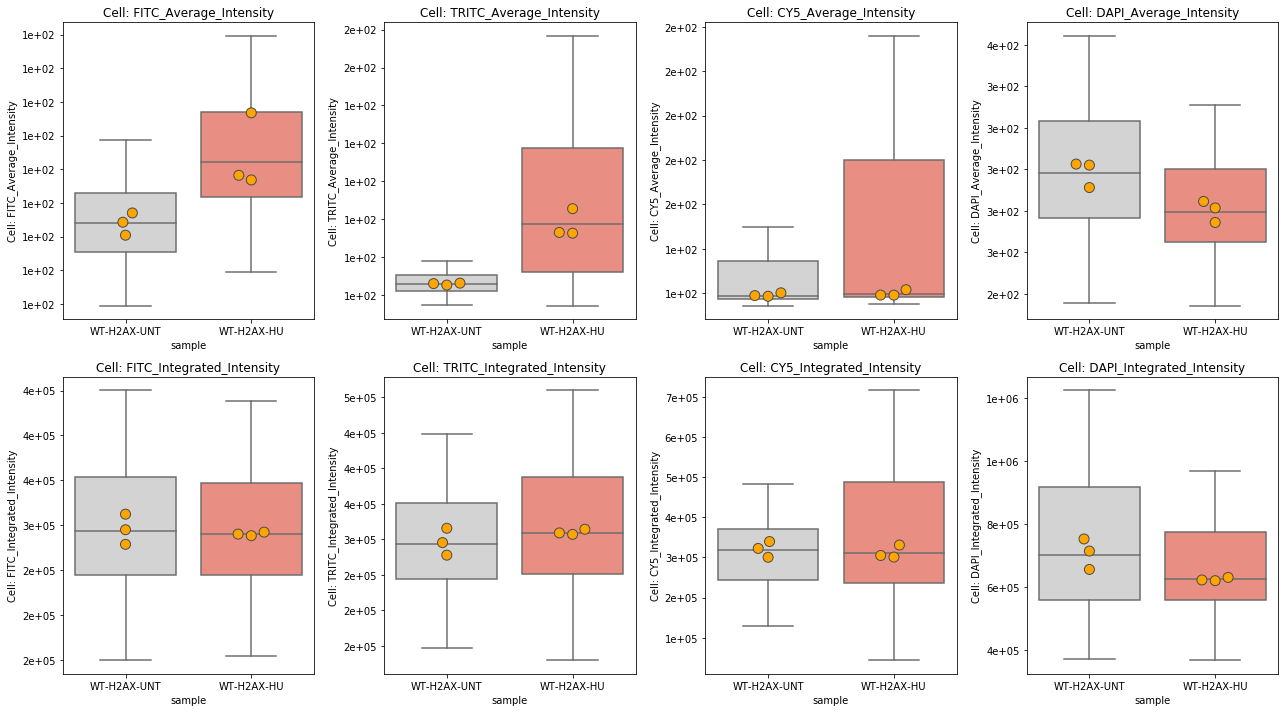

In [6]:
#Let's display a boxplot of intensity for each channel.
#Let's also display the median per well, to easily spot any weird well

#List of the 8 channels
list_channel = [GFP_avg, TRITC_avg, EDU_avg, DAPI_avg,GFP_int, TRITC_int,EDU_int, DAPI_int ]
order = ['WT-H2AX-UNT','WT-H2AX-HU']
fig, axs = plt.subplots(2,4, figsize=(18, 10))
axs = axs.flatten()

for i in range(0,len(list_channel)):
    ax=plt.subplot(2,4,i+1)
    ax.set_title(list_channel[i])
    ax= sns.boxplot(x="sample", y=list_channel[i],whis =0.9, showfliers = False, data=df2,
                   order =order, palette=["lightgray", "salmon"] )
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    perwell = df2.groupby(['sample', 'Well'])[list_channel[i]].median()
    perwell = perwell.reset_index()
    ax =sns.swarmplot(x="sample", y=list_channel[i], data=perwell, order=order,
              size=10, color = 'orange', edgecolor ='gray', linewidth =1)
    
plt.tight_layout()   
plt.show()


<H1>Grayscale bias</H1>

On the imageXpress the minimum "black intensity" is not 0, but around 110.
Meaning that the average intensity/integrated intensity is biased.
This background value should be removed as follow :
 <ul>
 <li>should be directly removed from the "average intensity"</li>
 <li>For the integrated intensity, it's a bit more complicated :<b>
     integrated intensity (int)is defined as follow :
     INT = (average intensity - Background) * Area
     </li>
 </ul>



In [7]:
BCK = 113 #background value 
#_cor for "corrected"
df2['DAPI_avg_cor'] = df2[DAPI_avg] - BCK
df2['TRITC_avg_cor'] = df2[TRITC_avg] - BCK
df2['FITC_avg_cor'] = df2[GFP_avg] - BCK
df2['CY5_avg_cor'] = df2[EDU_avg] - BCK

df2['DAPI_int_cor'] = df2['DAPI_avg_cor']* df2['Cell: DAPI_Area_Average']
df2['TRITC_int_cor'] = df2['TRITC_avg_cor'] * df2['Cell: DAPI_Area_Average']
df2['FITC_int_cor'] = df2['FITC_avg_cor'] * df2['Cell: DAPI_Area_Average']
df2['CY5_int_cor'] = df2['CY5_avg_cor'] * df2['Cell: DAPI_Area_Average']






<h1> Image based cytometry </h1>
Here, we'll display cell cycle profile of each sample as a cutometry experiment  :<br/>
X axis is DAPI content <br/>
Y axis is EDU <br/>
G1/S/G2 cells are displayed in a different colors<br/>
The percentage of cells on each phase will be displayed in the graph. <br/>
Because both samples have a diffeent

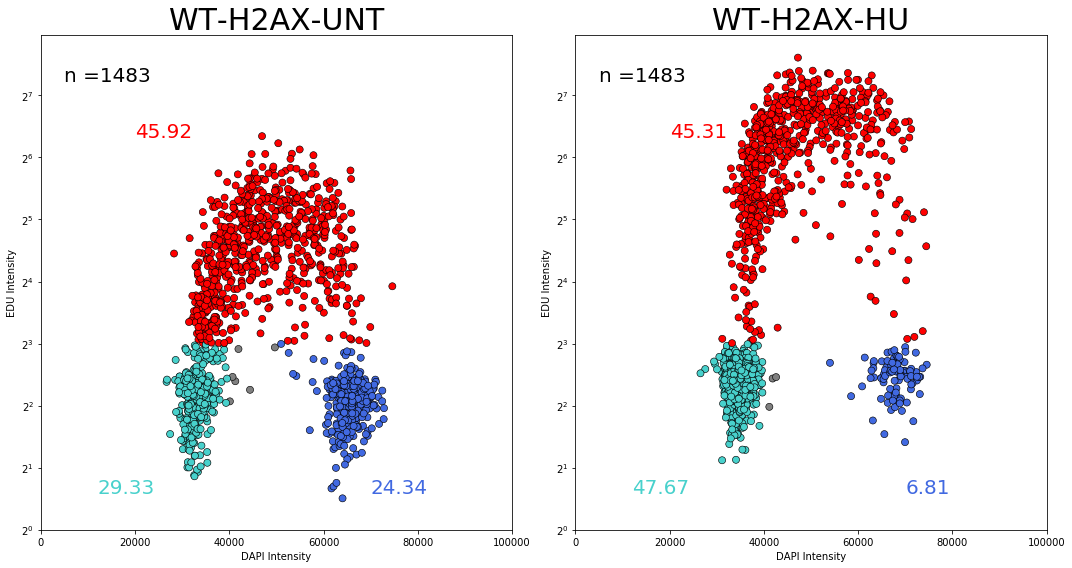

In [19]:
t = CategoricalDtype(categories=['WT-H2AX-UNT', 'WT-H2AX-HU'], ordered=True)

df2['sample'] = df2['sample'].astype(t)
#remove outliers (values that don't really make sense)

select =(df2['DAPI_int_cor'] < 75000) & (df2['DAPI_int_cor'] > 22500) 

#cellcycle function to define the cell cycle for each cell

def cellcycle(c):
    sphase = (c['CY5_avg_cor'] > 8)
    g1phase = (c['DAPI_int_cor'] < 40000) & (c['CY5_avg_cor'] < 8)
    g2phase =(c['DAPI_int_cor'] > 50000) & (c['CY5_avg_cor'] < 8)
    
    if sphase  :
        return "S"
    elif g1phase:
        return "G1"
    elif g2phase :
        return "G2"
    return "other"

df2['cell cycle'] = df2.apply(cellcycle, axis =1)
colors = {'S':'red',"G1" : 'mediumturquoise', "G2" : 'royalblue', 'other': 'gray'}


#RANDOM SELECTION

# first we have to find the samples with the minumum cell number.
#df2[select].groupby('sample').count().min() #599
df3 = df2[select]


size = df2[select].groupby('sample').count().min().iloc[0]       # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
randdf3= df3.groupby('sample', as_index=False).apply(fn)
randdf3.head()

fig, axs = plt.subplots(1,2, figsize=(15, 8))
axs = axs.flatten()
l=['xx']
for i in randdf3['sample'].unique():
    l.append(i)
    

for i in range(1,len(l)):
    y = randdf3.loc[(randdf3['sample'] == l[i]),'CY5_avg_cor']
    x= randdf3.loc[(randdf3['sample'] == l[i]), 'DAPI_int_cor']
    c= randdf3.loc[(randdf3['sample'] == l[i]), 'cell cycle']
    
    cycle = dict((c.value_counts()/len(c))*100)
   

    ax=plt.subplot(1,2,i)
    ax.set_title(l[i], size=30)
    plt.yscale('log', basey=2)
    plt.xlim(0,100000)
    plt.ylim(1,250)
    #plt.xticks([])
    plt.scatter(x,y, s=50, color=[colors[i] for i in c], linewidths = 0.6 , edgecolors = 'black')
    plt.xlabel('DAPI Intensity')
    plt.ylabel('EDU Intensity')
    plt.text(20000,80, round(cycle['S'], 2), size=20, color ='red')
    plt.text(12000,1.5, round(cycle['G1'], 2), size=20, color ='mediumturquoise')
    plt.text(70000,1.5, round(cycle['G2'], 2), size=20, color ='royalblue')
    plt.text(5000,150, "n =" + str(len(c)), size=20, color ='black')

    
plt.tight_layout()
#plt.savefig('plot/QIBC.eps', format='eps', dpi=1000)  
    
plt.show()

As expected, after 6H- 10mM HU, we see :
 - An increase of the G1/S propulation
 - An increase of cells in early S
 - A decrease of the G2 Population

<h1> h2AX analysis </h1>

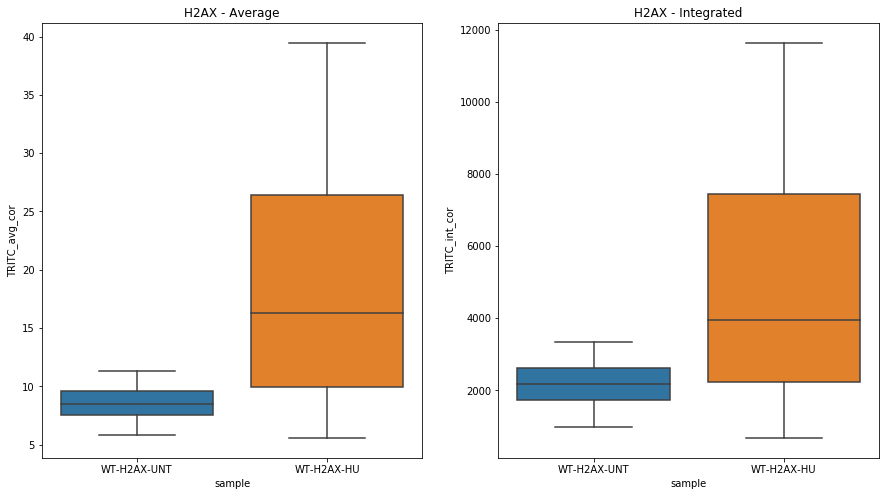

In [26]:
#Quick and dirty way 

fig, axs = plt.subplots(1,2, figsize=(15, 8))
ax=plt.subplot(1,2,1)
ax= sns.boxplot(x="sample", y="TRITC_avg_cor",whis =0.8, showfliers = False, data=df2)
plt.title("H2AX - Average")
ax=plt.subplot(1,2,2)
ax= sns.boxplot(x="sample", y="TRITC_int_cor",whis =0.8, showfliers = False, data=df2)
plt.title("H2AX - Integrated")

plt.show()

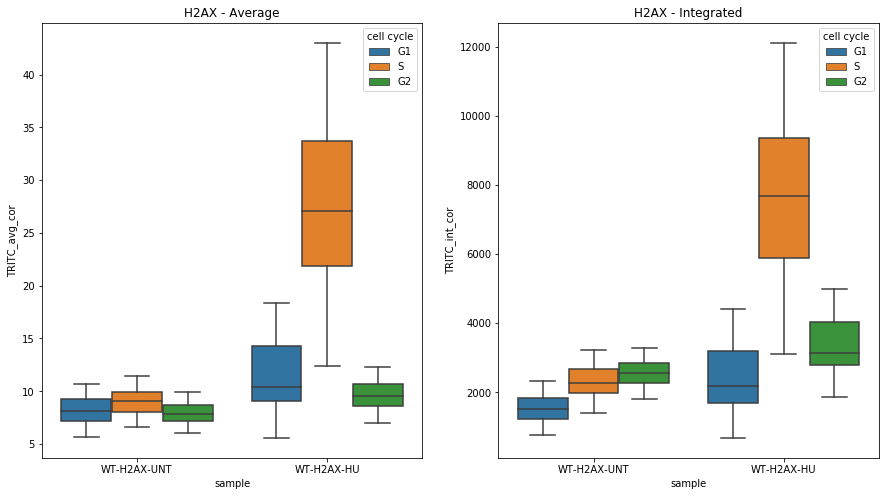

In [30]:
#nicer way 

fig, axs = plt.subplots(1,2, figsize=(15, 8))
ax=plt.subplot(1,2,1)

Hueoorder = ['G1','S','G2']
ax= sns.boxplot(x="sample", y="TRITC_avg_cor",whis =0.8, showfliers = False, data=df2, hue ='cell cycle', hue_order=Hueoorder)
plt.title("H2AX - Average")
ax=plt.subplot(1,2,2)
ax= sns.boxplot(x="sample", y="TRITC_int_cor",whis =0.8, showfliers = False, data=df2, hue ='cell cycle', hue_order=Hueoorder)
plt.title("H2AX - Integrated")

plt.show()

<h1>To be continued...</h1>